In [1]:
import pandas as pd
import numpy as np
import os
import gget
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import sys
import itertools
from sklearn.decomposition import PCA
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
import scipy

sys.path.append("../")
import utils as ut

In [2]:
cardDir =  "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/CARDInputs/"
xyPath =  "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/combinedEmbedding.csv"
xy = pd.read_csv(xyPath)


macTypes = [
    'Mac1',
    'Mac2',
    'Mac3',
    'Mac4',
    'Mac5',
]

print()

keys = ['ND', 'HFD8', 'HFD14']

rna = {}
labels = {}

for key in keys:
    print(f"{key}...")
    labelPath = f"{cardDir}{key}_macrophage_clusters.csv"
    lf = pd.read_csv(labelPath)
    
    lf = lf.drop_duplicates(subset='cellId')
    lf = lf[lf['cellType'].isin(macTypes)]
    
    lf = pd.merge(lf, xy[['x', 'y', 'cellId', 'colors']], 
                  how='left',
                  left_on='cellId',
                  right_on='cellId')
    

    cellIds = lf['cellId'].to_list()
    labels[key] = lf
    
    rnaPath = f"{cardDir}{key}_macrophage_rna.csv"
    rf = pd.read_csv(rnaPath)
    rf = rf.T
    new_header = rf.iloc[0] 
    rf = rf[1:] 
    rf.columns = new_header 
    rf.index.names = ['cellId']

    rf = rf[rf.index.isin(cellIds)]
    print(f"{key=} {lf.shape=} {rf.shape}")
    
    rf = ut.normalize(rf, 1e6)
    rna[key] = rf
    
print('done')


ND...
key='ND' lf.shape=(360, 6) (359, 31053)
HFD8...
key='HFD8' lf.shape=(2194, 6) (2188, 31053)
HFD14...
key='HFD14' lf.shape=(3893, 6) (3884, 31053)
done


pdf.shape=(6431, 14)


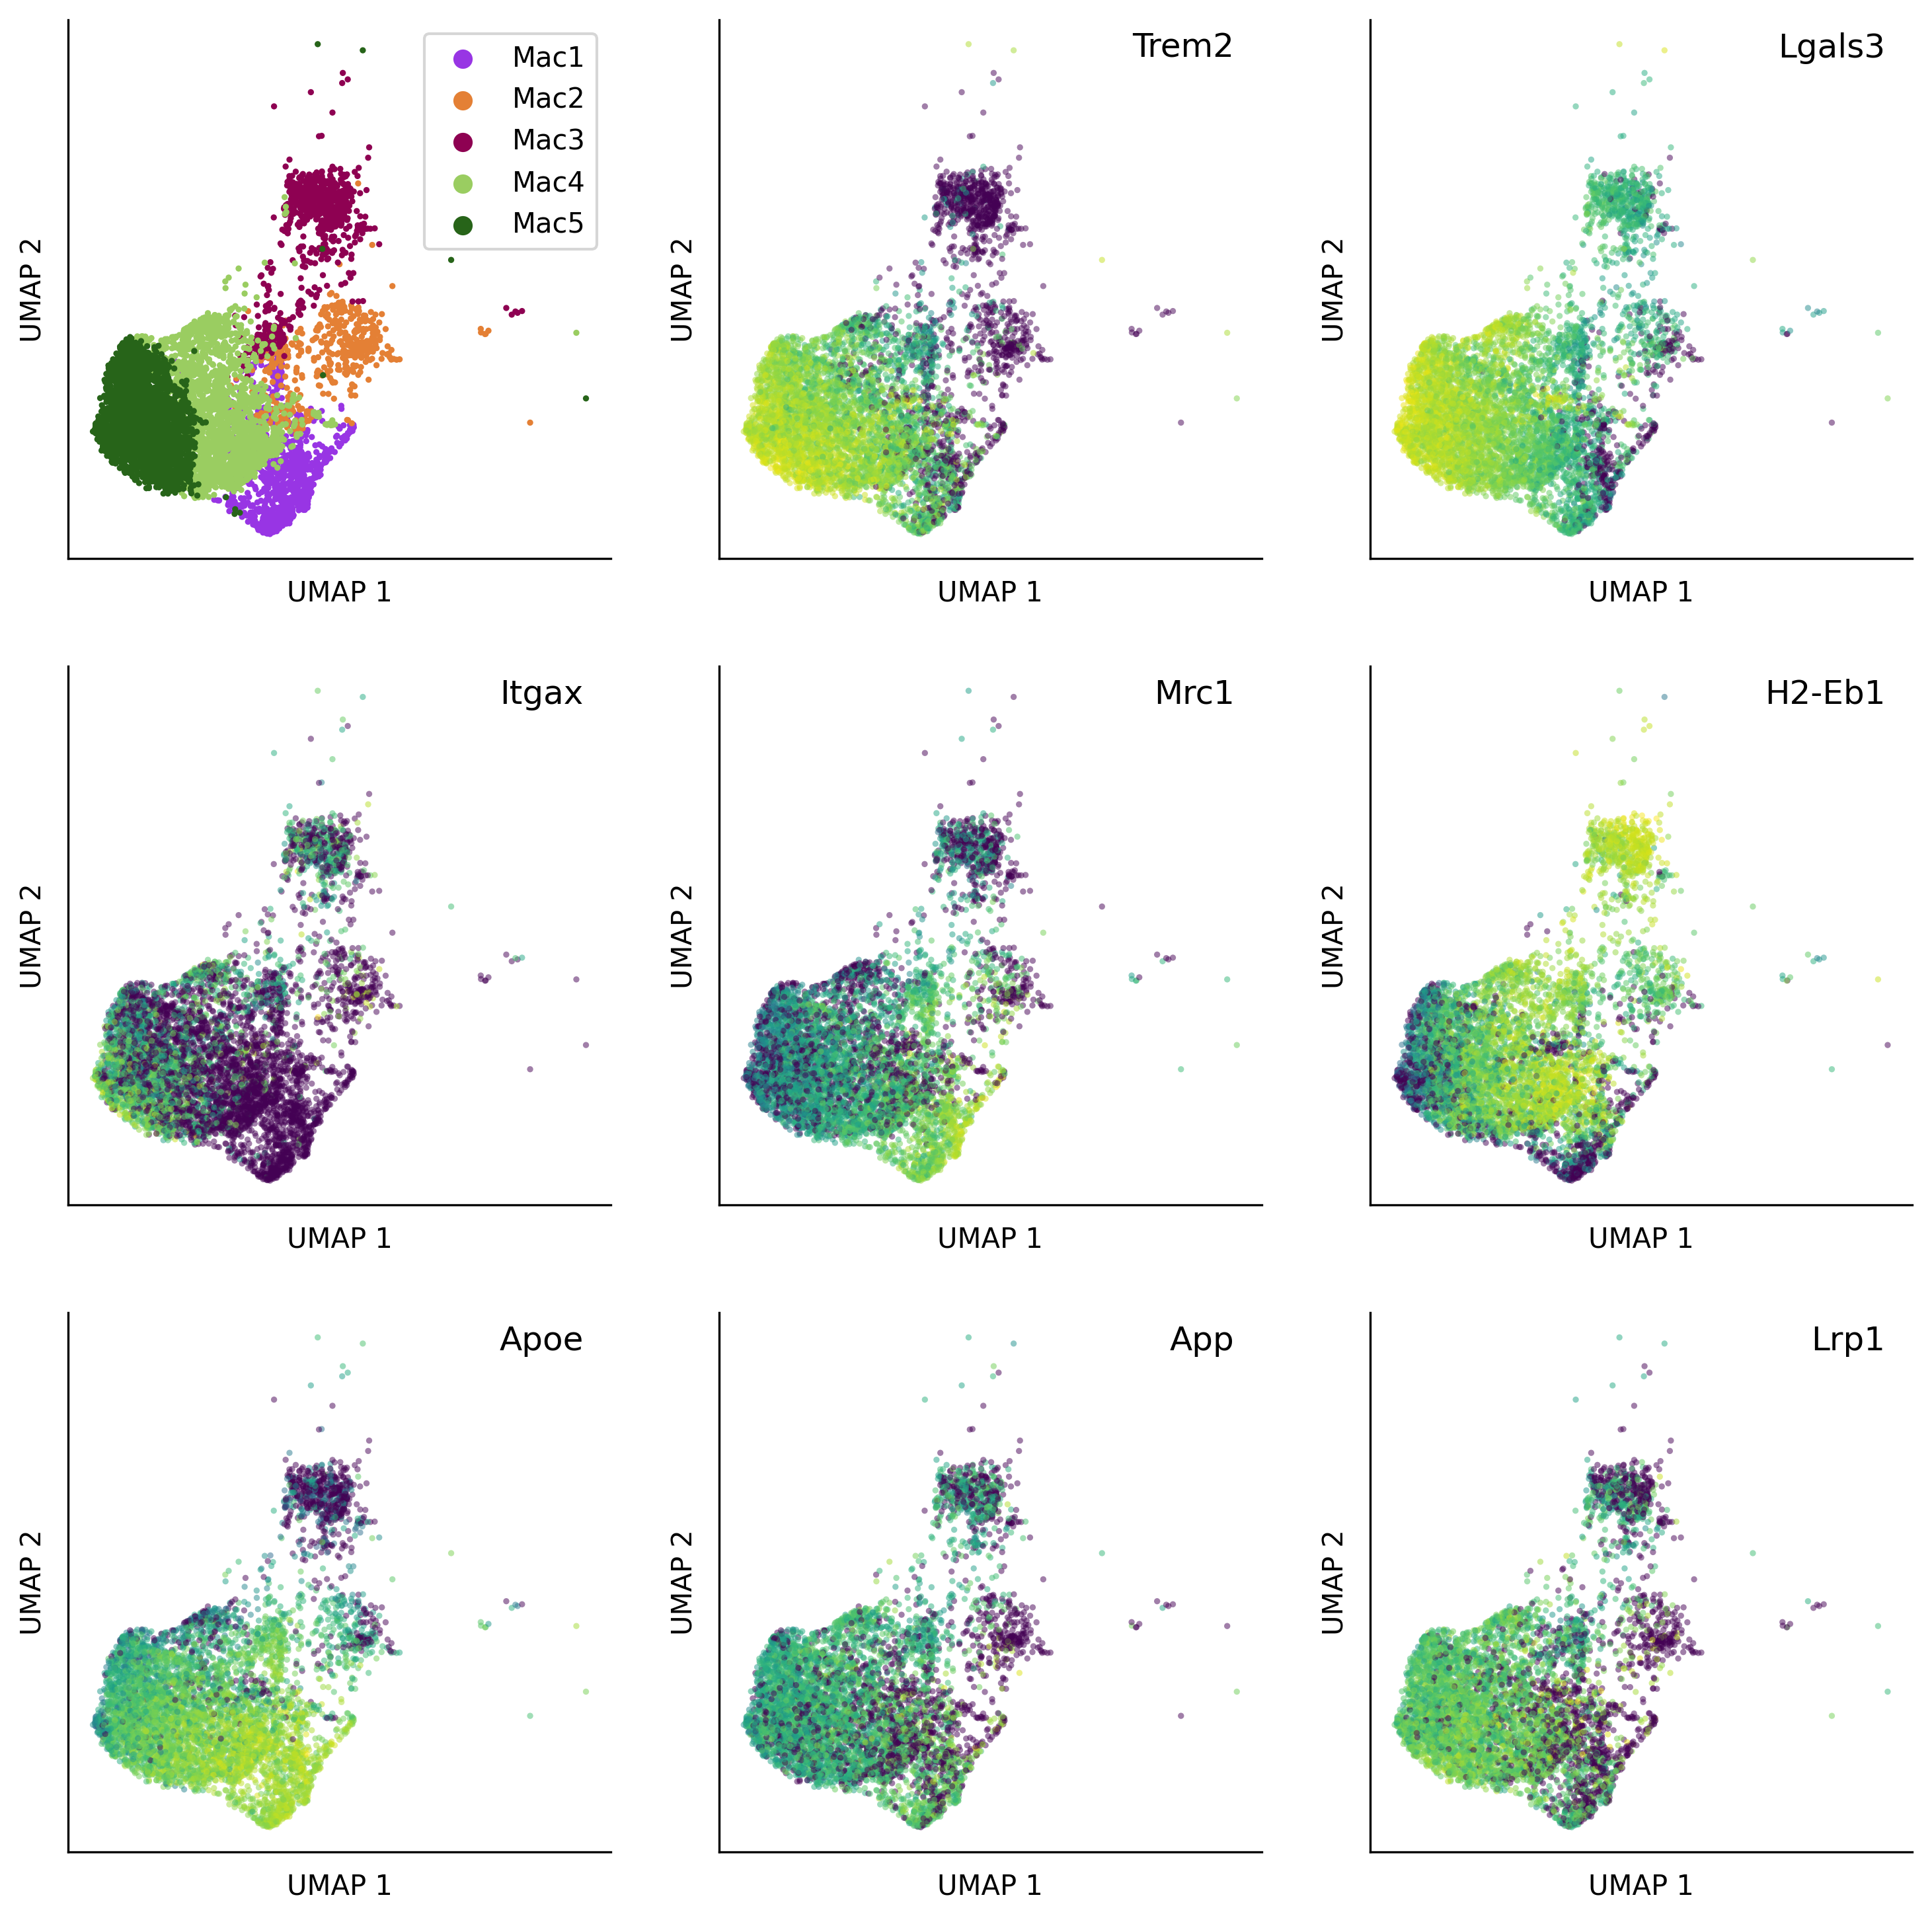

In [7]:
genes = [
    'TREM2',
    'LGALS3',
    'ITGAX',
    'MRC1',
    'H2-EB1',
    'APOE',
    'APP',
    'LRP1',
]

pdf = []

for key in keys:
    rf = rna[key][genes]
    lf = labels[key].drop_duplicates(subset='cellId')

    tmp = pd.merge(lf, rf, how='left',
                   left_on='cellId',
                   right_index=True)

    pdf.append(tmp)
    

pdf = pd.concat(pdf)
pdf = pdf.sort_values(by='cellType')
pdf[genes] = np.log1p(pdf[genes].astype(float))
print(f"{pdf.shape=}")

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 12, 12
plt.rcParams['figure.facecolor'] = "w"

fig, axs = plt.subplots(3, 3)
axs = axs.ravel()

for i in range(0, len(genes)+1):
    
    if i == 0:
        sns.scatterplot(data=pdf, 
                        x='x',
                        y='y',
                        hue='cellType',
                        s=5,
                        ec='None',
                        palette=ut.MACCOLORS,
                        ax=axs[i])
        
        sns.move_legend(axs[i],
                        title="",
                        loc='upper right')

    else:
        sns.scatterplot(data=pdf, 
                x='x',
                y='y',
                hue=genes[i-1],
                legend=False,
                s=5,
                palette='viridis',
                alpha=0.5,
                ec='None',
                ax=axs[i],)

        if genes[i-1] == 'H2-EB1':
            axs[i].set_title("H2-Eb1", 
                 y=0.9, 
                 x=0.95,
                 horizontalalignment="right")
        else:
            axs[i].set_title(genes[i-1].lower().capitalize(), 
                             y=0.9, 
                             x=0.95,
                             horizontalalignment="right")
            
    axs[i].set_xlabel("UMAP 1")
    axs[i].set_xticks([])
    axs[i].set_ylabel("UMAP 2")
    axs[i].set_yticks([])

sns.despine()

In [4]:
outdir = "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/FIGURE_DATA/SUPP/"
fname = "expression_UMAP.csv"
pdf.to_csv(f"{outdir}{fname}", index=False)
pdf.head()

,cellId,cellType,sampleInfo,x,y,colors,TREM2,LGALS3,ITGAX,MRC1,H2-EB1,APOE,APP,LRP1
0,AAAGAACGTCTACAGT.1,Mac1,ND,3.089298,-1.726030,#fdbf6f,6.596868,0.000000,0.0,8.387490,6.596868,10.746564,5.905085,6.596868
3537,TGGTGATCATATCTCT.1,Mac1,HFD14,1.875225,-1.642601,#fdbf6f,6.951968,7.932199,0.0,5.855267,6.951968,9.613665,0.000000,0.000000
28,AAAGTCCTCAGGAAAT.1,Mac1,HFD14,2.540232,-1.048775,#fdbf6f,0.000000,6.526683,0.0,0.000000,9.090280,9.297898,6.526683,6.526683
27,AAAGTCCTCAACTACG.1,Mac1,HFD14,2.026346,-3.116629,#fdbf6f,6.670322,6.447496,0.0,7.362835,0.000000,10.322339,5.755932,5.065943
19,AAAGGGCTCAGCCTCT.1,Mac1,HFD14,2.295027,-1.299789,#fdbf6f,5.502805,6.598697,0.0,7.445216,8.494658,9.082354,0.000000,0.000000


In [5]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [ ]:
ut.makeColorbar('viridis',
                0.2, 2.5, 
                'Expression (log)',
                'vertical', 
                ['Low', 'High'])